##### <i> Ce notebook a pour objectif d'étudier les ventes hebdomadaire dans la station de Paris et la station de Rouen d'un point de vue statistique afin de faire du </i> <a> Forecasting </a>.



# Required libraries and environment :


In [1]:
import pandas as pd  # dataframe structure
from pandas import Series
from pandas import DataFrame
import numpy as np  # array structure
import seaborn as sns # visualization
import matplotlib.pyplot as plt # plot
import matplotlib.dates as mdates
import glob, os  # dealing with OS and Files, reading files etc 
import pickle # saving model, data, etc : serialization
from statsmodels.tsa.arima_model import ARIMA # model for forecasting 
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller # test for stationnarity
from pandas.tools.plotting import lag_plot # plot for randomness
from statsmodels.tsa.arima_model import ARIMAResults
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from math import sqrt
import time
from datetime import date, timedelta
import scipy
import itertools
import warnings
warnings.filterwarnings("ignore")  #ignore warning
%matplotlib inline

# Load Data :

In [3]:
train = pd.read_csv('./Data/train.csv', sep=';', index_col= 0)  # set Id to be the index column
pd.options.display.max_columns=100

In [4]:
train.head()

,implant,date,article_nom,id_categorie_6,qte_article_vendue,id_categorie_5,id_categorie_4,cat6_nom,cat5_nom,cat4_nom,t_9h_rouen,n_9h_rouen,rr3_9h_rouen,ff_9h_rouen,t_15h_rouen,n_15h_rouen,rr3_15h_rouen,ff_15h_rouen,t_9h_paris,n_9h_paris,rr3_9h_paris,ff_9h_paris,t_15h_paris,n_15h_paris,rr3_15h_paris,ff_15h_paris,aller_zone_1,aller_zone_2,aller_zone_3,aller_zone_4,aller_zone_5,aller_zone_6,retour_zone_1,retour_zone_2,retour_zone_3,retour_zone_4,retour_zone_5,retour_zone_6
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
39fc404102d5,NF059473,2016-01-01,Cookie Cara Noix Pecan 70G Michel Augustin,1001672,"0,56",1001664,1001639,Patiss PréEmballé,Patisserie,Boulan Vienn Patiss,"278,25","100,0","0,2","4,0","280,05","100,0","0,0","7,6","278,05","101,0","0,0","2,5","280,55","100,0","0,0","3,2",0,0,0,0,0,0,0,0,0,0,0,0
aa697ce32b43,NF059473,2016-01-01,Cookie Choc Blc 70G Michel Augustin,1001672,"1,11",1001664,1001639,Patiss PréEmballé,Patisserie,Boulan Vienn Patiss,"278,25","100,0","0,2","4,0","280,05","100,0","0,0","7,6","278,05","101,0","0,0","2,5","280,55","100,0","0,0","3,2",0,0,0,0,0,0,0,0,0,0,0,0
291a469e1b50,NF059473,2016-01-01,Cookie Choc Nois 70G Michel Augustin,1001672,"0,56",1001664,1001639,Patiss PréEmballé,Patisserie,Boulan Vienn Patiss,"278,25","100,0","0,2","4,0","280,05","100,0","0,0","7,6","278,05","101,0","0,0","2,5","280,55","100,0","0,0","3,2",0,0,0,0,0,0,0,0,0,0,0,0
2dbc07dbc8f0,NF059473,2016-01-01,Cookie Choco 70G Michel Augustin,1001672,"0,56",1001664,1001639,Patiss PréEmballé,Patisserie,Boulan Vienn Patiss,"278,25","100,0","0,2","4,0","280,05","100,0","0,0","7,6","278,05","101,0","0,0","2,5","280,55","100,0","0,0","3,2",0,0,0,0,0,0,0,0,0,0,0,0
e664714361d6,NF059473,2016-01-01,Croissant 60G Cuit/Place Neuhauser,1001674,"4,08",1001665,1001639,Vienn cuit/place,Viennoiserie,Boulan Vienn Patiss,"278,25","100,0","0,2","4,0","280,05","100,0","0,0","7,6","278,05","101,0","0,0","2,5","280,55","100,0","0,0","3,2",0,0,0,0,0,0,0,0,0,0,0,0


# Prepare Data :

In [5]:
## Convertir la quantitée d'article vendue en un nombre réel.

train["qte_article_vendue"] = train["qte_article_vendue"].apply(lambda var: var.replace(",","."))
train["qte_article_vendue"] = pd.to_numeric(train["qte_article_vendue"])

## convertir la date en datetime:

train['date']=pd.to_datetime(train['date'])

In [6]:
test = train[train['date'] >= '2017-03-01']
train = train[train['date'] < '2017-03-01']


In [7]:
series_rouen_train = train[train.implant=='NF059473'].loc[:,['date','qte_article_vendue']].groupby('date').sum().loc[:,'qte_article_vendue']
series_rouen_test = test[test.implant=='NF059473'].loc[:,['date','qte_article_vendue']].groupby('date').sum().loc[:,'qte_article_vendue']
series_rouen_test

date
2017-03-01    123.56
2017-03-02    119.97
2017-03-03    109.36
2017-03-04     53.82
2017-03-05    111.34
2017-03-06    113.06
2017-03-07    117.36
2017-03-08    106.62
2017-03-09     90.61
2017-03-10     97.48
2017-03-11     77.30
2017-03-12    122.73
2017-03-13    119.43
2017-03-14     78.76
2017-03-15    102.93
2017-03-16    120.53
2017-03-17    136.10
2017-03-18     65.36
2017-03-19    112.25
2017-03-20    114.64
2017-03-21    103.36
2017-03-22     98.56
2017-03-23    105.71
2017-03-24    115.12
2017-03-25     94.22
2017-03-26    170.73
2017-03-27    139.57
2017-03-28    103.07
2017-03-29    102.41
2017-03-30    121.90
               ...  
2017-04-01     65.39
2017-04-02    151.47
2017-04-03    166.26
2017-04-04    106.22
2017-04-05    134.37
2017-04-06    121.99
2017-04-07    161.46
2017-04-08    203.95
2017-04-09    373.03
2017-04-10    251.45
2017-04-11    113.65
2017-04-12    192.65
2017-04-13    179.24
2017-04-14    193.42
2017-04-15    204.46
2017-04-16    239.00
2017-04-

In [8]:
series_paris_train = train[train.implant=='NF078544'].loc[:,['date','qte_article_vendue']].groupby('date').sum().loc[:,'qte_article_vendue']
series_paris_test = test[test.implant=='NF078544'].loc[:,['date','qte_article_vendue']].groupby('date').sum().loc[:,'qte_article_vendue']
series_paris_test

date
2017-03-01     30.21
2017-03-02     28.90
2017-03-03     45.43
2017-03-04     34.87
2017-03-05     23.61
2017-03-06     25.44
2017-03-07     24.36
2017-03-08     34.36
2017-03-09     31.00
2017-03-10     55.04
2017-03-11     34.91
2017-03-12     28.29
2017-03-13     34.49
2017-03-14     36.64
2017-03-15     32.25
2017-03-16     25.76
2017-03-17     47.44
2017-03-18     43.59
2017-03-19     35.71
2017-03-20     37.48
2017-03-21     33.15
2017-03-22     32.74
2017-03-23     31.42
2017-03-24     66.97
2017-03-25     41.44
2017-03-26     28.96
2017-03-27     35.86
2017-03-28     34.78
2017-03-29     27.51
2017-03-30     39.21
               ...  
2017-04-01     78.36
2017-04-02     68.17
2017-04-03     73.61
2017-04-04     43.02
2017-04-05     55.24
2017-04-06     42.98
2017-04-07     98.60
2017-04-08    152.77
2017-04-09    108.60
2017-04-10    104.01
2017-04-11     57.63
2017-04-12     65.86
2017-04-13     67.92
2017-04-14    147.31
2017-04-15    125.54
2017-04-16     43.48
2017-04-

# visulizations :

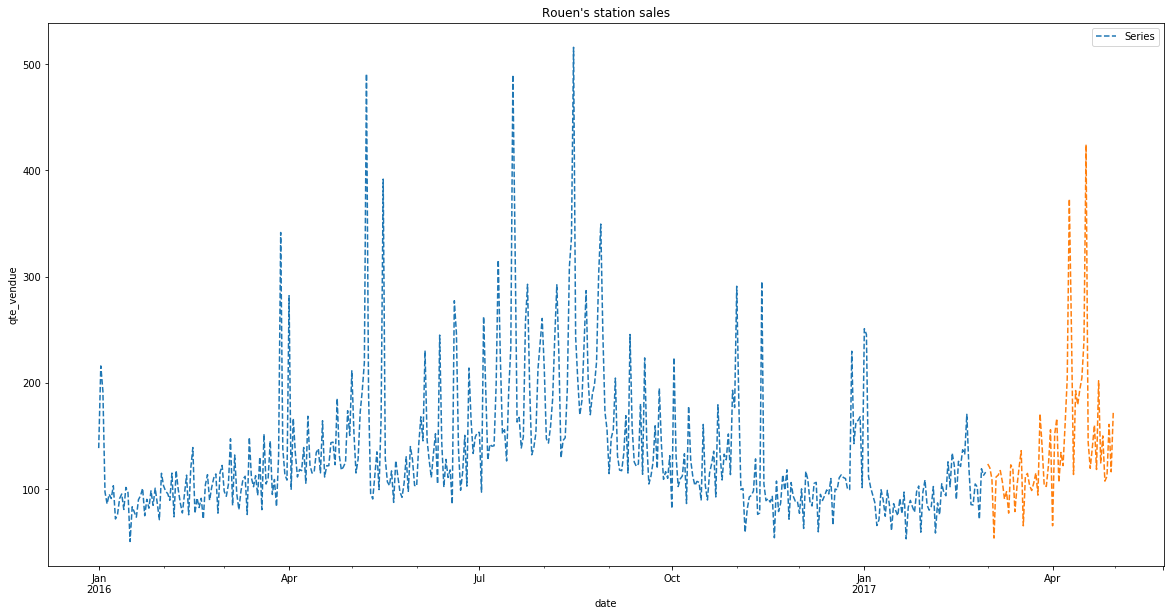

In [9]:
plt.figure(figsize=(20,10))
ts = pd.Series(series_rouen_train)
tss = pd.Series(series_rouen_test)
plt.ylabel('qte_vendue')
plt.title("Rouen's station sales")
ts.plot(style='--', label='Series'); plt.legend()
tss.plot(style='--', label='Series')


In [16]:
import holidays

date_2016={}
date_2017={}
for date, name in sorted(holidays.France(years=[2016,2017]).items()):
    print(date,name)
    if date.year == 2016:
        date_2016[name]=date
    if date.year == 2017:
        date_2017[name]=date        
        
    


holidays_2016 = pd.DataFrame({
  'holiday': list(date_2016.keys()),
  'ds': pd.to_datetime(list(date_2016.values())),
  'lower_window': -1,
  'upper_window': 1,
})

holidays_2017 = pd.DataFrame({
  'holiday': list(date_2017.keys()),
  'ds': pd.to_datetime(list(date_2017.values())),
  'lower_window': -1,
  'upper_window': 1,
})

holiday = pd.DataFrame({
  'holiday': "Vacances scolaires",
  'ds': pd.to_datetime(['2016-08-01','2017-08-01']),
  'lower_window': -45,
  'upper_window': 30,
})

holidays = pd.concat((holidays_2016, holidays_2017, holiday))
holidays.reset_index(drop=True,inplace=True)
holidays

2016-01-01 Jour de l'an
2016-03-28 Lundi de Pâques
2016-05-01 Fête du Travail
2016-05-05 Ascension
2016-05-08 Armistice 1945
2016-05-16 Lundi de Pentecôte
2016-07-14 Fête nationale
2016-08-15 Assomption
2016-11-01 Toussaint
2016-11-11 Armistice 1918
2016-12-25 Noël
2017-01-01 Jour de l'an
2017-04-17 Lundi de Pâques
2017-05-01 Fête du Travail
2017-05-08 Armistice 1945
2017-05-25 Ascension
2017-06-05 Lundi de Pentecôte
2017-07-14 Fête nationale
2017-08-15 Assomption
2017-11-01 Toussaint
2017-11-11 Armistice 1918
2017-12-25 Noël


,holiday,ds,lower_window,upper_window
0,Jour de l'an,2016-01-01,-1,1
1,Lundi de Pâques,2016-03-28,-1,1
2,Fête du Travail,2016-05-01,-1,1
3,Ascension,2016-05-05,-1,1
4,Armistice 1945,2016-05-08,-1,1
5,Lundi de Pentecôte,2016-05-16,-1,1
6,Fête nationale,2016-07-14,-1,1
7,Assomption,2016-08-15,-1,1
8,Toussaint,2016-11-01,-1,1
9,Armistice 1918,2016-11-11,-1,1


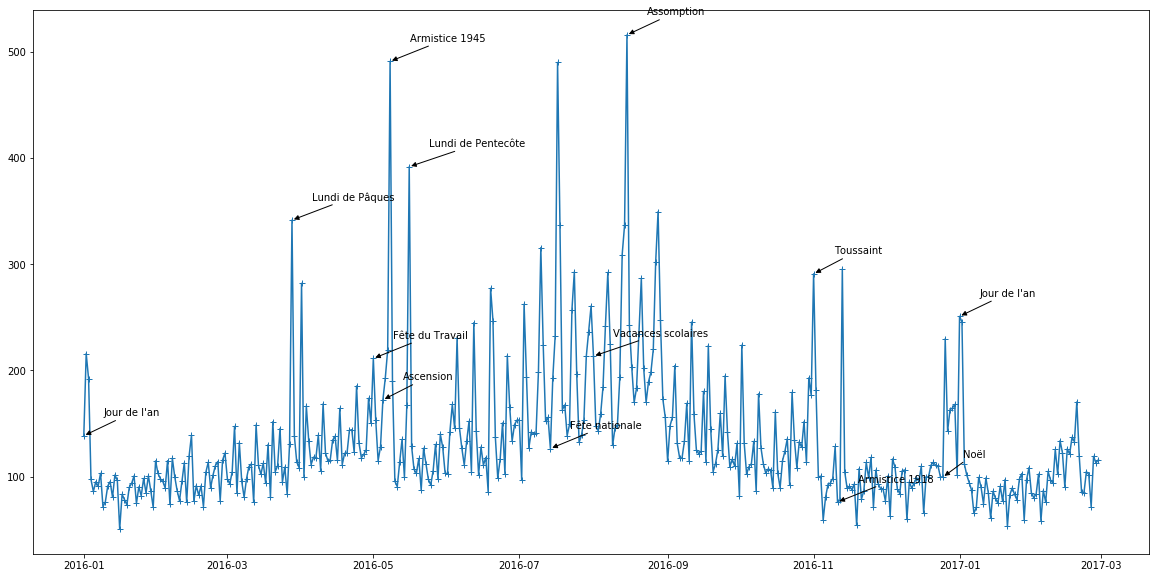

In [17]:
#plt.figure(figsize=(20,10))
x=pd.to_datetime(ts.index)
y=ts.values

fig, ax = plt.subplots(figsize=(20,10))
ax.plot_date(x, y, fmt='+',linestyle='-')

for i in range(holidays.shape[0]):
    try:
        ind = list(x).index(holidays.ds[i])
        ax.annotate(holidays.holiday[i], (mdates.date2num(x[ind]), y[ind]), xytext=(20, 20), 
                  textcoords='offset points', arrowprops=dict(facecolor='black', arrowstyle='-|>'))
    except:
        pass

#fig.autofmt_xdate()
plt.show()


# Let's analyse the most purchased product in Rouen:

In [18]:
#Fetching the N most purchased products#
from scipy.stats import itemfreq
N=1
labels_freq_pd = itemfreq(train[train['implant']=='NF059473'][train["qte_article_vendue"]!=0]["article_nom"])
labels_freq_pd = labels_freq_pd[labels_freq_pd[:, 1].argsort()[::-1]] #[::-1] ==> to sort in descending order
    
main_labels = labels_freq_pd[:,0][0:N]

        

    

print("Most {} purchased products are : {}".format(N,main_labels))

Most 1 purchased products are : ['Baguette Poulet Crudites 250G Dm']


In [19]:
baguette = train[(train.implant=='NF059473')&(train.article_nom=='Baguette Poulet Crudites 250G Dm')]
baguette.head(3)

,implant,date,article_nom,id_categorie_6,qte_article_vendue,id_categorie_5,id_categorie_4,cat6_nom,cat5_nom,cat4_nom,t_9h_rouen,n_9h_rouen,rr3_9h_rouen,ff_9h_rouen,t_15h_rouen,n_15h_rouen,rr3_15h_rouen,ff_15h_rouen,t_9h_paris,n_9h_paris,rr3_9h_paris,ff_9h_paris,t_15h_paris,n_15h_paris,rr3_15h_paris,ff_15h_paris,aller_zone_1,aller_zone_2,aller_zone_3,aller_zone_4,aller_zone_5,aller_zone_6,retour_zone_1,retour_zone_2,retour_zone_3,retour_zone_4,retour_zone_5,retour_zone_6
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
983e7f381eb1,NF059473,2016-01-01,Baguette Poulet Crudites 250G Dm,1001785,10.09,1001730,1001688,Sand Ind Gd Bag,Sandw Ind Gd Baguette,Baguettes,"278,25","100,0","0,2","4,0","280,05","100,0","0,0","7,6","278,05","101,0","0,0","2,5","280,55","100,0","0,0","3,2",0,0,0,0,0,0,0,0,0,0,0,0
2f50e929a8d6,NF059473,2016-01-02,Baguette Poulet Crudites 250G Dm,1001785,2.14,1001730,1001688,Sand Ind Gd Bag,Sandw Ind Gd Baguette,Baguettes,"282,45","90,0","0,0","7,3","281,45","100,0","4,0","10,0","282,55","75,0","0,0","5,7","283,45","90,0","-0,1","7,4",0,0,0,0,0,0,1,0,0,0,0,0
100eb29a7ef2,NF059473,2016-01-03,Baguette Poulet Crudites 250G Dm,1001785,0.25,1001730,1001688,Sand Ind Gd Bag,Sandw Ind Gd Baguette,Baguettes,"278,95","100,0","0,4","7,6","279,95","100,0","4,0","8,4","279,55","100,0","-0,1","4,6","280,15","100,0","3,8","6,6",0,0,0,0,0,0,1,1,1,1,1,1


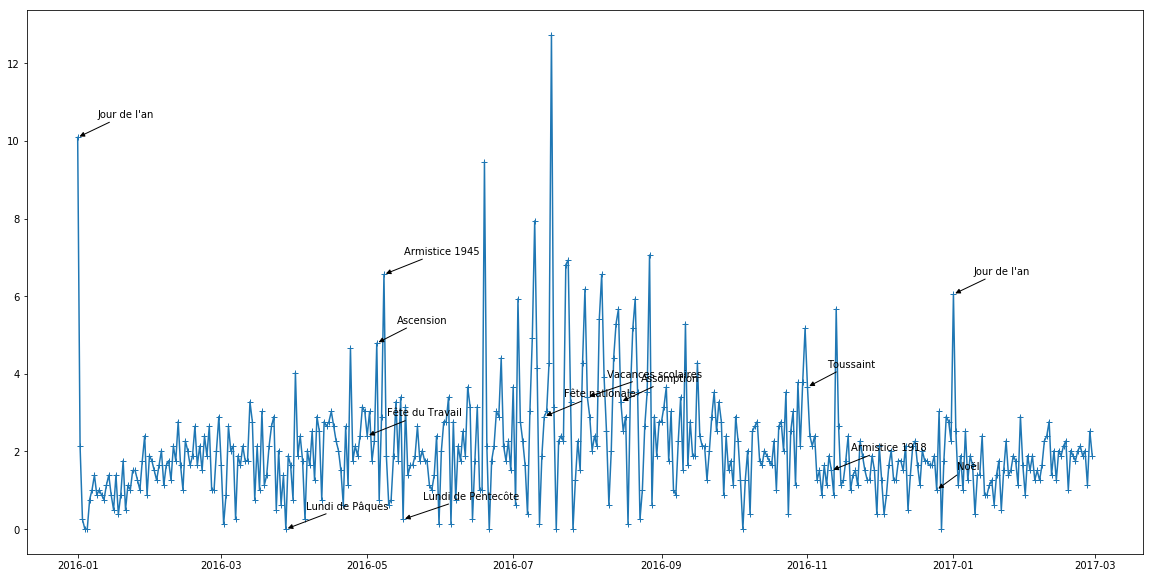

In [20]:
baguette_series=pd.Series(baguette.loc[:,['date','qte_article_vendue']].groupby('date').sum()['qte_article_vendue'])
x=pd.to_datetime(baguette_series.index)
y=baguette_series.values

fig, ax = plt.subplots(figsize=(20,10))
ax.plot_date(x, y, fmt='+',linestyle='-')

for i in range(holidays.shape[0]):
    try:
        ind = list(x).index(holidays.ds[i])
        ax.annotate(holidays.holiday[i], (mdates.date2num(x[ind]), y[ind]), xytext=(20, 20), 
                  textcoords='offset points', arrowprops=dict(facecolor='black', arrowstyle='-|>'))
    except:
        pass


#fig.autofmt_xdate()
plt.show()


In [21]:
baguette_series = pd.DataFrame({
    'ds': baguette_series.index,
    'y' : baguette_series.values
})

In [23]:
baguette_series.head()

,ds,y
0,2016-01-01,10.09
1,2016-01-02,2.14
2,2016-01-03,0.25
3,2016-01-04,0.00
4,2016-01-05,0.00


In [27]:
from fbprophet import Prophet
m = Prophet(holidays=holidays)
m.add_seasonality(
    name='weekly', period=7, fourier_order=5, prior_scale=0.9)
m.fit(baguette_series)

from datetime import date 
d1 = date(2016, 1, 1)  # start date 
#d2 = date(2017, 5, 15)  # end date 
d2 = date(2017, 12, 30)  # end date 

delta = d2 - d1         # timedelta
future=[]

for i in range(delta.days + 1):
    future.append(str(d1 + timedelta(i)))

future = pd.DataFrame({
    'ds':pd.to_datetime(future)
})

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
future[:10]

,ds
0,2016-01-01
1,2016-01-02
2,2016-01-03
3,2016-01-04
4,2016-01-05
5,2016-01-06
6,2016-01-07
7,2016-01-08
8,2016-01-09
9,2016-01-10


In [29]:
forecast = m.predict(future)

In [30]:
forecast.head(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Armistice 1918,Armistice 1918_lower,Armistice 1918_upper,Armistice 1945,Armistice 1945_lower,Armistice 1945_upper,Ascension,Ascension_lower,Ascension_upper,Assomption,Assomption_lower,Assomption_upper,Fête du Travail,Fête du Travail_lower,Fête du Travail_upper,Fête nationale,Fête nationale_lower,Fête nationale_upper,Jour de l'an,Jour de l'an_lower,Jour de l'an_upper,Lundi de Pentecôte,Lundi de Pentecôte_lower,Lundi de Pentecôte_upper,Lundi de Pâques,Lundi de Pâques_lower,Lundi de Pâques_upper,Noël,Noël_lower,Noël_upper,Toussaint,Toussaint_lower,Toussaint_upper,Vacances scolaires,Vacances scolaires_lower,Vacances scolaires_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-01,1.292333,7.120355,8.860853,1.292333,1.292333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.111412,6.111412,6.111412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.692726,6.692726,6.692726,6.111412,6.111412,6.111412,0.581315,0.581315,0.581315,0.0,0.0,0.0,7.985059
1,2016-01-02,1.298882,1.119901,2.756345,1.298882,1.298882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.939908,0.939908,0.939908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.638488,0.638488,0.638488,0.939908,0.939908,0.939908,-0.301420,-0.301420,-0.301420,0.0,0.0,0.0,1.937371
2,2016-01-03,1.305432,0.741171,2.453497,1.305432,1.305432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.307600,0.307600,0.307600,0.000000,0.000000,0.000000,0.307600,0.307600,0.307600,0.0,0.0,0.0,1.613032


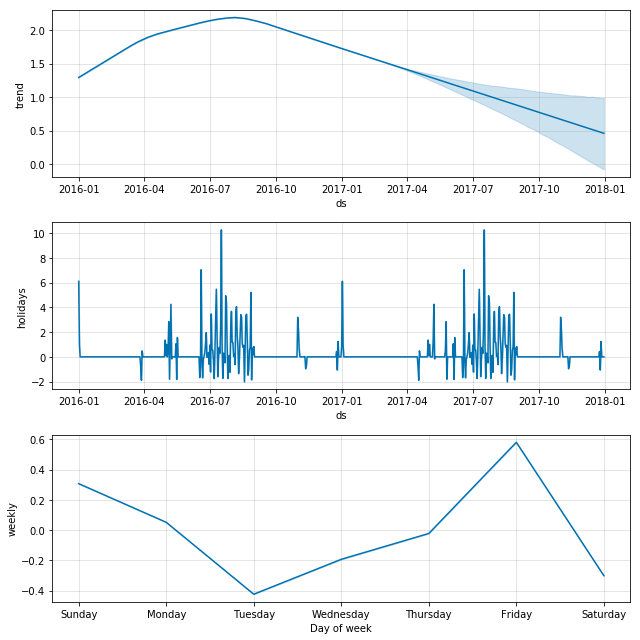

In [31]:
fig = m.plot_components(forecast)

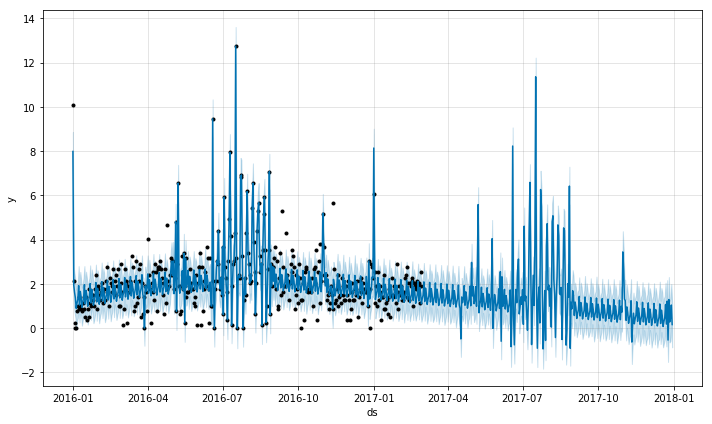

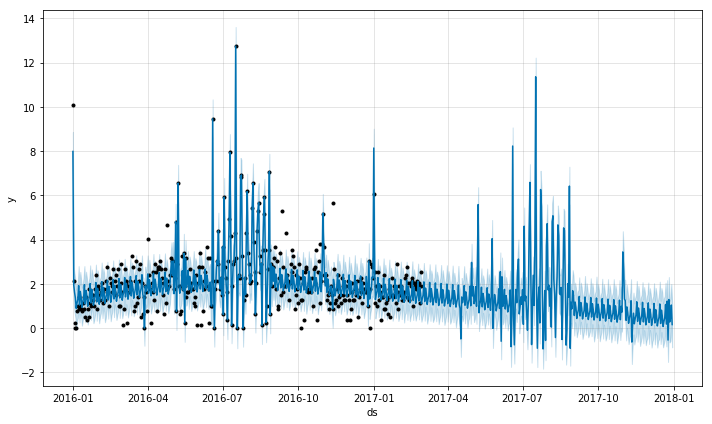

In [32]:
m.plot(forecast)

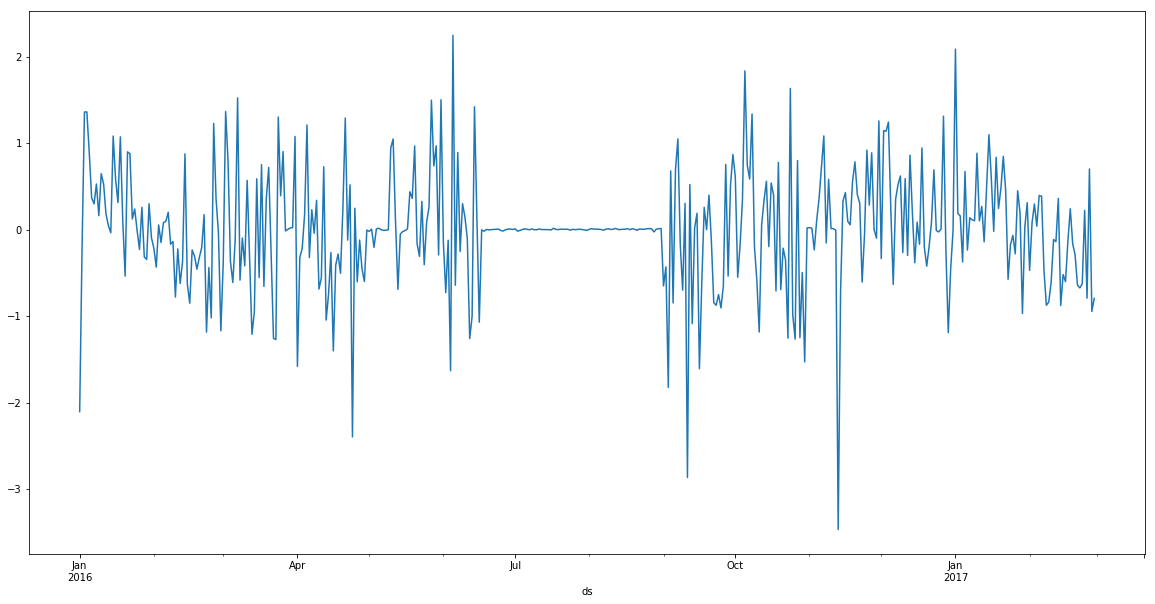

In [33]:
plt.figure(figsize=(20,10))
pred = pd.Series(forecast.loc[:,['ds','yhat']].groupby('ds').sum().loc[:,'yhat'])
truth = pd.Series(baguette_series.loc[:,['ds','y']].groupby('ds').sum().loc[:,'y'])

(pred[:425]-truth).plot()

In [34]:
l=sorted(baguette_series.y.unique())
l=[l[i+1]-l[i] for i in range(len(l)-1)]
pu = min(l)


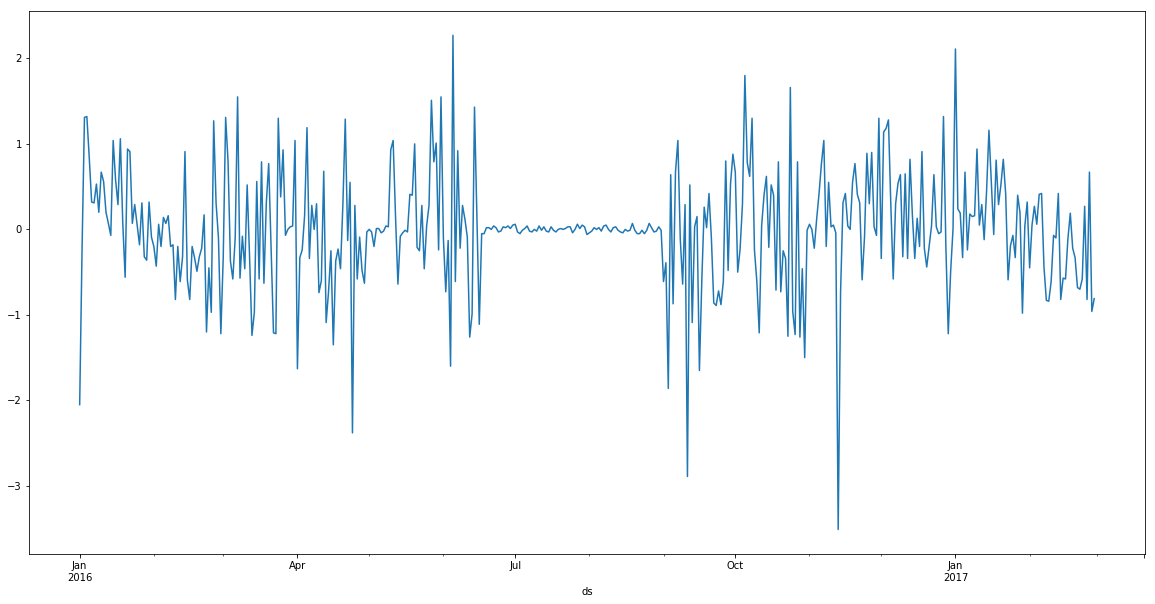

In [35]:
for i in range(len(pred)):
    if pred[i]<=0:
        pred[i]=0
    else:
        pred[i] = int((pred[i]/pu)+0.5)*pu
        
plt.figure(figsize=(20,10))
(pred[:425]-truth).plot()


In [36]:
baguette_test = test[(test.implant=='NF059473')&(test.article_nom=='Baguette Poulet Crudites 250G Dm')]

baguette_series_test=pd.Series(baguette_test.loc[:,['date','qte_article_vendue']].groupby('date').sum()['qte_article_vendue'])



print('RMSE score = ',mean_squared_error(list(baguette_series_test), list(pred[425:425+61]))**0.5, '/ 0.0')


RMSE score =  1.3478580457434728 / 0.0


In [37]:
pred_=list(baguette_series[(baguette_series.ds>='2016-03-01')&(baguette_series.ds<='2016-04-30')].y)
print('RMSE score = ',mean_squared_error(list(baguette_series_test), pred_)**0.5, '/ 0.0')

RMSE score =  1.6033832058862387 / 0.0


## Without holidays

In [54]:
holidays

,holiday,ds,lower_window,upper_window
0,Jour de l'an,2016-01-01,-1,1
1,Lundi de Pâques,2016-03-28,-1,1
2,Fête du Travail,2016-05-01,-1,1
3,Ascension,2016-05-05,-1,1
4,Armistice 1945,2016-05-08,-1,1
5,Lundi de Pentecôte,2016-05-16,-1,1
6,Fête nationale,2016-07-14,-1,1
7,Assomption,2016-08-15,-1,1
8,Toussaint,2016-11-01,-1,1
9,Armistice 1918,2016-11-11,-1,1


In [56]:
date(2016, 1, 1)+timedelta(1)

datetime.date(2016, 1, 2)

In [94]:
holidays_b = holidays.copy(deep = True)

In [106]:
holidays_b

,holiday,ds,lower_window,upper_window
0,Jour de l'an,2016-01-01,-1,1
1,Lundi de Pâques,2016-03-28,-1,1
2,Fête du Travail,2016-05-01,-1,1
3,Ascension,2016-05-05,-1,1
4,Armistice 1945,2016-05-08,-1,1
5,Lundi de Pentecôte,2016-05-16,-1,1
6,vacs,2016-06-30,-1,1
7,finvacs,2016-01-09,-1,1
8,Toussaint,2016-11-01,-1,1
9,Armistice 1918,2016-11-11,-1,1


In [197]:
holidays_b.iloc[6]  = pd.Series(["debvacs",date(2016,6,15),-1,1], index = ["holiday","ds","lower_window","upper_window"])

In [198]:
timedeltas = []
for k in range(0,len(holidays_b["ds"])-3):
    timedeltas.append((holidays_b["ds"][k] + timedelta(1),holidays_b["ds"][k+1] - timedelta(1)))
    

In [205]:
from fbprophet import Prophet
m = Prophet()
m.add_seasonality(
    name='weekly', period=7, fourier_order=5, prior_scale=0.9)
m.fit(baguette_series)

from datetime import date 
d1 = date(2016, 1, 3)  # start date 
d2 = date(2016, 6, 30)
#d2 = date(2017, 5, 15)  # end date 
d3 = date(2016, 9, 1)  # end date 
d4= date(2017, 6, 30)

delta1 = d2 - d1         # timedelta
delta2 = d4 - d3
future=[]
for k in timedeltas:
    if((str(k[0])[:10],str(k[1])[:10]) == (str(date(2016,6,16)), str(date(2016,8,31)))):
        print("CC")
        pass
    else:
        delta = k[1] - k[0]
        for i in range(delta.days + 1):
            future.append(str(k[0] + timedelta(i)))
"""    
for i in range(delta1.days + 1):
    future.append(str(d1 + timedelta(i)))

for i in range(delta2.days + 1):
    future.append(str(d3 + timedelta(i)))
"""

future = pd.DataFrame({
    'ds':pd.to_datetime(future)
})

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CC


In [206]:
forecast = m.predict(future)

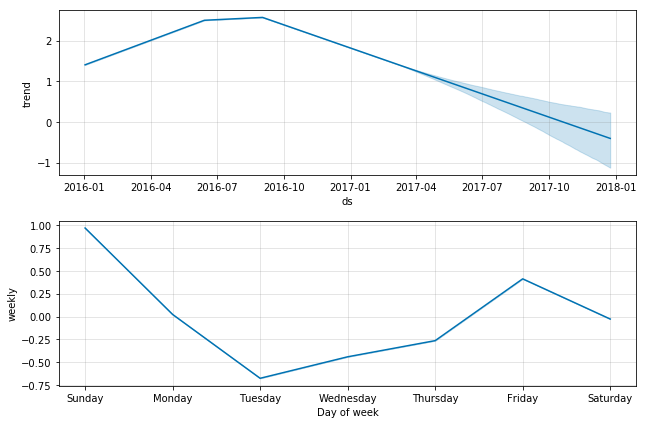

In [207]:
fig = m.plot_components(forecast)

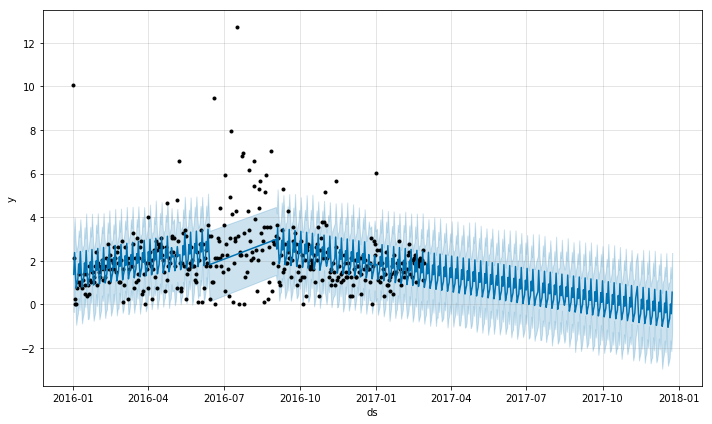

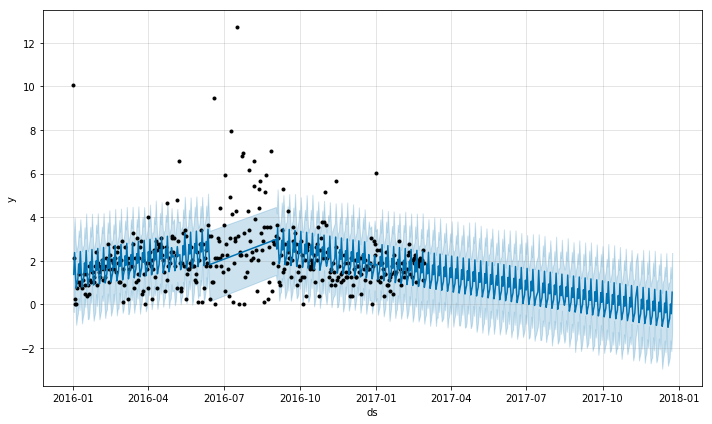

In [208]:
m.plot(forecast)

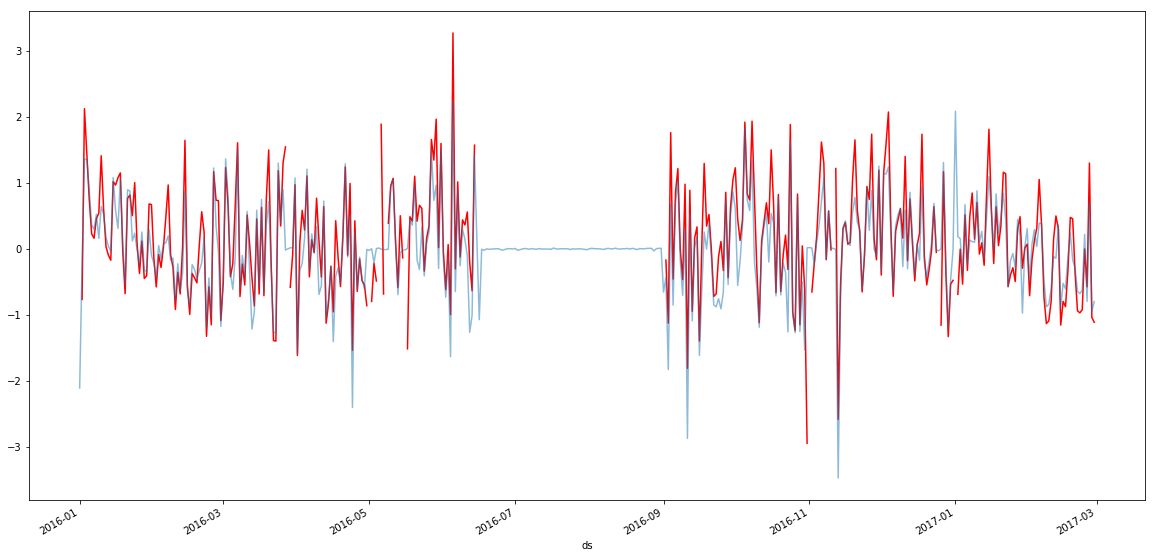

In [209]:
plt.figure(figsize=(20,10))
pred = pd.Series(forecast.loc[:,['ds','yhat']].groupby('ds').sum().loc[:,'yhat'])
truth = pd.Series(baguette_series.loc[:,['ds','y']].groupby('ds').sum().loc[:,'y'])

(pred[:425]-truth).plot(color = "r")
(pred2[:425]-truth).plot(alpha = 0.5)

In [176]:
from fbprophet import Prophet
m = Prophet(holidays=holidays)
m.add_seasonality(
    name='weekly', period=7, fourier_order=5, prior_scale=0.9)
m.fit(baguette_series)

from datetime import date 
d1 = date(2016, 1, 1)  # start date 
#d2 = date(2017, 5, 15)  # end date 
d2 = date(2017, 12, 30)  # end date 

delta = d2 - d1         # timedelta
future=[]

for i in range(delta.days + 1):
    future.append(str(d1 + timedelta(i)))

future = pd.DataFrame({
    'ds':pd.to_datetime(future)
})

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [177]:
forecast2 = m.predict(future)

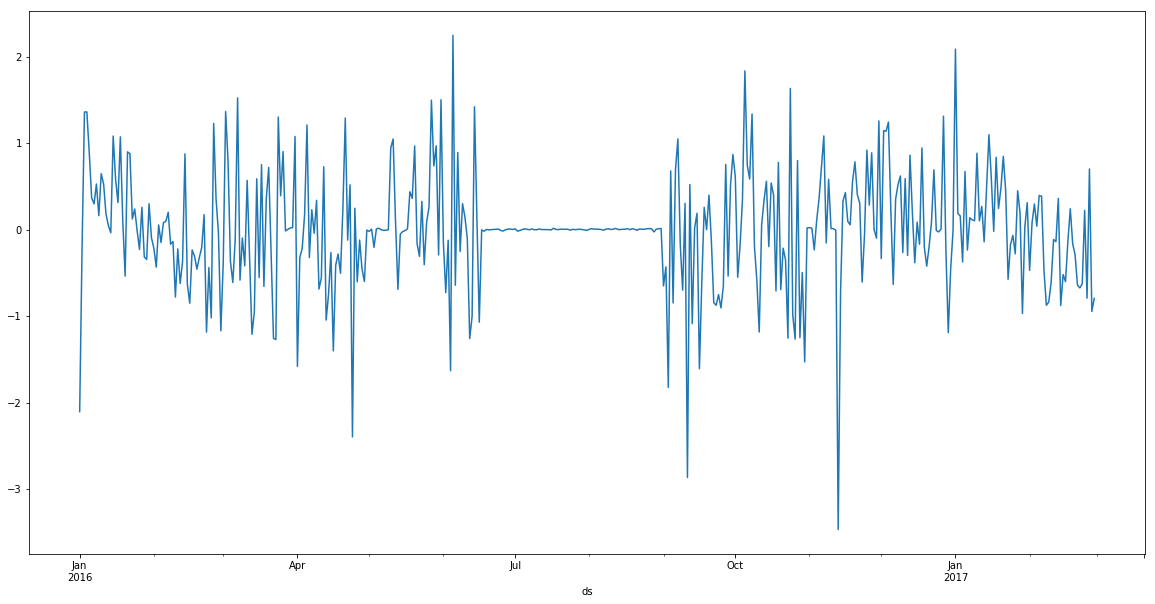

In [179]:
plt.figure(figsize=(20,10))
pred2 = pd.Series(forecast2.loc[:,['ds','yhat']].groupby('ds').sum().loc[:,'yhat'])
truth = pd.Series(baguette_series.loc[:,['ds','y']].groupby('ds').sum().loc[:,'y'])

(pred2[:425]-truth).plot()